In [3]:
import matplotlib.pyplot as plt
import torch
from medusa.model.utils import *
from medusa.model.medusa_choices import *
import networkx as nx

## Medusa Tree Configuration Explained
The `medusa_choices` is a nested list representing choices within the Medusa tree structure. The outer list corresponds to the number of nodes in the tree, while each inner list indicates the positions of ancestors and their corresponding nodes based on their depth in the tree.

In [4]:
medusa_choices = mc_sim_7b_63

In [5]:
plt.figure(figsize=(40, 20)) 

paths = medusa_choices[:]

G = nx.DiGraph()

for path in paths:
    for i in range(len(path)):
        if i == 0:
            parent = 'root'
        else:
            parent = tuple(path[:i])
        child = tuple(path[:i+1])
        G.add_edge(parent, child)

# Use the Graphviz layout for drawing.
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, width=2, edge_color="gray")
plt.savefig('medusa_configuration_explained.png', dpi=300)


ImportError: requires pygraphviz http://pygraphviz.github.io/

<Figure size 4000x2000 with 0 Axes>

In [4]:
medusa_buffers = generate_medusa_buffers(medusa_choices, device='cpu')

In [5]:
for item in medusa_buffers:
    print(item)

medusa_attn_mask
tree_indices
medusa_position_ids
retrieve_indices


## Medusa Attention Mask
You can see the attention mask for tree attention below. Each node can only associate with its ancestors.

Medusa attention mask shape:  torch.Size([1, 1, 64, 64])


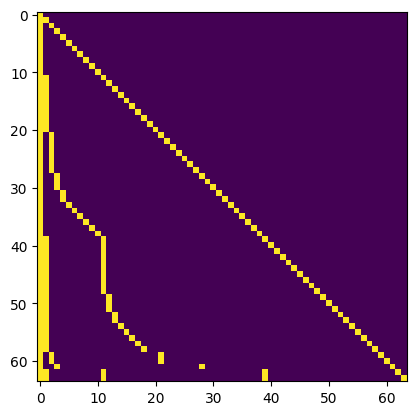

In [6]:
medusa_attn_mask = medusa_buffers['medusa_attn_mask']
print('Medusa attention mask shape: ', medusa_attn_mask.shape)
plt.imshow(medusa_attn_mask[0,0].cpu().numpy())

## Explanation of Code and Outputs
We start with a simple tensor (you can treat the values are top-1/2 from two Medusa heads) named `demo_tensor`:
``` python 
[2, 3, 0, 0, 0, 0, 0, 0 ...] # 1st depth we choose top 2
[4, 5, 6, 0, 0, 0, 0, 0 ...] # 2nd depth we choose top 3

```
Given the `medusa_choices` as `[[0], [0, 0], [0, 1], [0, 2], [1], [1, 0], [1, 1], [1, 2]]`, the tensor with the root `[1]` (which is the original head's top-1) can be visualized as:

``` python
[1]
[2, 3]
[4, 5, 6]
```

### Tree Indices
The `tree_indices` provide us with the positions that we are looking at from the original tensor. 

Some of the positions are repeated, indicating that they are fetched multiple times due to the combination.

The tree indices for the above tensor are:
``` python
[0, 1, 2, 3, 4, 5, 3, 4, 5]
```

The tree looks like this:

``` python
1
|-- 2
|   |-- 4
|   |-- 5
|   |-- 6
|-- 3
|   |-- 4
|   |-- 5
|   |-- 6
```

When we use these indices to map values from the `demo_tensor`, we get the following flatten tree representation of the tensor:

``` python
[1, 2, 3, 4, 5, 6, 4, 5, 6]
```

### Medusa Position IDs
These are essentially depths for positions in the tree representation to make sure tokens on the same depth are applied with same position embedding.

```python
[0, 1, 1, 2, 2, 2, 2, 2, 2] # Medusa position IDs
 |  |  |  |  |  |  |  |  |
[1, 2, 3, 4, 5, 6, 4, 5, 6] # Flatten tree representation of the tensor
```

### Retrieve Indices

`retrieve_indices` provides a map from tree to cartesian product of the demo tensor. 

Retrieve indices: 

```python
[0, 2, 8]
[0, 2, 7]
[0, 2, 6]
[0, 1, 5]
[0, 1, 4]
[0, 1, 3]
```

When mapping values from the flatten tree using these indices, we get:

``` python
[1, 3, 6]
[1, 3, 5]
[1, 3, 4]
[1, 2, 6]
[1, 2, 5]
[1, 2, 4]
```


In [7]:
demo_tensor = torch.zeros(2,10).long()
demo_tensor[0,0] = 2
demo_tensor[0,1] = 3
demo_tensor[1,0] = 4
demo_tensor[1,1] = 5
demo_tensor[1,2] = 6
print('Demo tensor: \n', demo_tensor)
demo_tensor = demo_tensor.flatten()
demo_tensor = torch.cat([torch.ones(1).long(), demo_tensor])
print('='*50)
medusa_choices = [[0], [0, 0], [0, 1], [0, 2], [1], [1, 0], [1, 1], [1, 2]]
medusa_buffers = generate_medusa_buffers(medusa_choices, device='cpu')
tree_indices = medusa_buffers['tree_indices']
medusa_position_ids = medusa_buffers['medusa_position_ids']
retrieve_indices = medusa_buffers['retrieve_indices']
print('Tree indices: \n', tree_indices.tolist())
print('Tree reprentation of the tensor: \n', demo_tensor[tree_indices].tolist())
print('='*50)
print('Medusa position ids: \n', medusa_position_ids.tolist())
print('='*50)
print('Retrieve indices: \n', retrieve_indices.tolist())
demo_tensor_tree = demo_tensor[tree_indices]
demo_tensor_tree_ext = torch.cat([demo_tensor_tree, torch.ones(1).long().mul(-1)])
print('Retrieve reprentation of the tensor: \n', demo_tensor_tree_ext[retrieve_indices].tolist())
print('='*50)

Demo tensor: 
 tensor([[2, 3, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 5, 6, 0, 0, 0, 0, 0, 0, 0]])
Tree indices: 
 [0, 1, 2, 11, 12, 13, 11, 12, 13]
Tree reprentation of the tensor: 
 [1, 2, 3, 4, 5, 6, 4, 5, 6]
Medusa position ids: 
 [0, 1, 1, 2, 2, 2, 2, 2, 2]
Retrieve indices: 
 [[0, 2, 8], [0, 2, 7], [0, 2, 6], [0, 1, 5], [0, 1, 4], [0, 1, 3]]
Retrieve reprentation of the tensor: 
 [[1, 3, 6], [1, 3, 5], [1, 3, 4], [1, 2, 6], [1, 2, 5], [1, 2, 4]]
